In [1]:
import tools
import param
import cartesian
import racks
import calibration
import samples
import json
import importlib
import random as rnd
import time
import low_level_comm as llc

In [2]:
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
import numpy as np

In [3]:
def waitFromTimeStamp(timestamp, wait_seconds):
    curr_timestamp = time.time()
    elapsed_time = curr_timestamp - timestamp
    remaining_sleep_time = wait_seconds - elapsed_time
    if remaining_sleep_time > 0:
        time.sleep(remaining_sleep_time)

In [4]:
def dropTipToWaste(tool, x_slot, y_slot, z):
    tool.robot.move(z=z)
    x, y = param.calcSquareSlotCenterFromVertices(x_slot, y_slot)
    tool.robot.move(x=x, y=y)
    tool.dropTip()

In [5]:
llc.listSerialPorts()

['COM3', 'COM6', 'COM10', 'COM14']

In [6]:
ar = cartesian.arnie(cartesian_port="COM10", docker_port="COM6")

In [11]:
ar.home()

In [8]:
stp = tools.stationary_touch_probe(ar)

ERROR:root:matchPortsWithDevices(): could not execute finiding device in list.
ERROR:root:matchPortsWithDevices(): Provided patterns_list: ['stationary touch probe']
ERROR:root:None


# Defining racks to be used in the protocol

In [12]:
# Tips
p1000_tip_rack = racks.consumables(rack_name='p1000_tips_1', rack_type='p1000_tips')
p200_tip_rack = racks.consumables(rack_name='p200_tips_1', rack_type='p200_tips')
p20_tip_rack = racks.consumables(rack_name='p20_tips_1', rack_type='p20_tips')
p1000_tip_rack.replaceConsumables()
# Some of the tips are missing from the box
p1000_tip_rack.removeConsumableItems([(4,7), (5,7), (7,7), (8, 6), (8, 7)])
p200_tip_rack.replaceConsumables()
p20_tip_rack.replaceConsumables()
# Tube racks
ep1 = racks.rack(rack_name='eppendorf_1', rack_type='eppendorf')
magep1 = racks.rack(rack_name='eppendorf_magnetic_1', rack_type='eppendorf_magnetic')
r50 = racks.rack(rack_name='50mL_rack_1', rack_type='50mL')

# Defining samples

In [112]:
# Initializing samples (total 5 samples)
sample_list = [samples.sample(sample_name='t_ep_'+str(x), sample_type='eppendorf_tube') for x in range(5)]

In [113]:
# Placing samples into the initial rack
[x[0].place(ep1, x[1], 3) for x in zip(sample_list, range(5))]

[None, None, None, None, None]

In [114]:
sample_list[0].sample_data

{'sample_name': 't_ep_0',
 'sample_type': 'eppendorf_tube',
 'rack': <racks.rack at 0x20c898106c8>,
 'x_well': 0,
 'y_well': 3}

In [115]:
# Defining starting volume of each sample
vol_list = [50, 50, 40, 25, 25]

# Pre-filling tubes with "sample" according to the volume

In [64]:
#p200 = tools.pipettor.getTool(robot=ar, tool_name='p200_tool')
p200 = tools.pipettor(robot=ar, tool_name='p200_tool')

In [65]:
xt, yt, zt = calibration.calibrateTool(p200, stp)

In [66]:
water = samples.sample(sample_name='water', sample_type='eppendorf_tube')
water.place(ep1, 7, 0)
water.setVolume(1300)

In [69]:
xn, yn = p200_tip_rack.getNextConsumable()
p200.pickUpTip(p200_tip_rack, xn, yn, raise_z=300)
p200.distributeLiquid(water, sample_list, vol_list)
dropTipToWaste(tool=p200, x_slot=5, y_slot=3, z=300)

In [70]:
p200.returnTool()

In [117]:
# Run this only if you fill samples manually
[x[0].setVolume(x[1]) for x in zip(sample_list, vol_list)]

[None, None, None, None, None]

In [118]:
sample_list[0].getVolume()

50

In [73]:
# Tube with magnetic beads
magbeads = samples.sample(sample_name='magbeads', sample_type='50mL_tube')
magbeads.place(r50, 0, 0)
# Assuming we have 20 mL of magnetic beads
magbeads.setVolume(20000)

In [74]:
# Tubes to transfer intermediate DNA into
upper_cut_samples = [samples.sample(sample_name='ucs_'+str(x), sample_type='eppendorf_tube') for x in range(5)]

In [75]:
# Empty tubes for elution
result_samples = [samples.sample(sample_name='result_'+str(x), sample_type='eppendorf_tube') for x in range(5)]

In [76]:
# Waste tube
waste = samples.sample(sample_name='waste', sample_type='50mL_tube')
waste.place(r50, 1, 0)
waste.setVolume(0)

In [77]:
# 80% ethanol tube
ethanol = samples.sample(sample_name='ethanol', sample_type='50mL_tube')
ethanol.place(r50, 2, 0)
ethanol.setVolume(50000)

In [78]:
# Placing samples into the initial rack
[x[0].place(ep1, x[1], 2) for x in zip(upper_cut_samples, range(5))]

[None, None, None, None, None]

In [79]:
[x[0].place(ep1, x[1], 0) for x in zip(result_samples, range(5))]

[None, None, None, None, None]

In [80]:
[x.setVolume(0) for x in upper_cut_samples]

[None, None, None, None, None]

# Defining DNA size cutoffs

In [120]:
upper_cutoff_list = [1000, 500, 700, 350, 1000]
lower_cutoff_list = [250, 100, 100, 150, 200]

# Factory beads calibration table

In [178]:
retained_fragments_dict = {
    1200: 0.5,
    1100: 0.5,
    1000: 0.5,
    450: 0.6,
    350: 0.7,
    300: 0.8,
    250: 0.9,
    150: 1.5,
    100: 3.0,
}

In [179]:
lists = sorted(retained_fragments_dict.items())
x, y = zip(*lists)
x = np.array(x)
y = np.array(y)

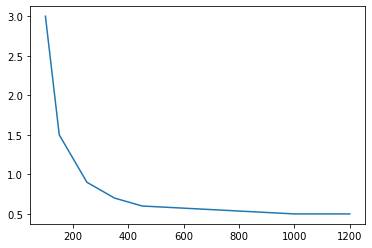

In [180]:
plt.plot(x, y)
plt.show()

## Fitting curve to simpulate retaining fraction vs. beads amount calibration table

In [190]:
def func(x, d, e, f):
    return d + e * 1/x + f * 1/x**2

In [191]:
popt, pcov = curve_fit(func, x, y)

In [192]:
# Coefficients for amount of beads calculations
popt

array([ 4.99325349e-01, -9.91043764e+00,  2.57585836e+04])

In [193]:
x_sim = np.array([x for x in range(100, 1200)])

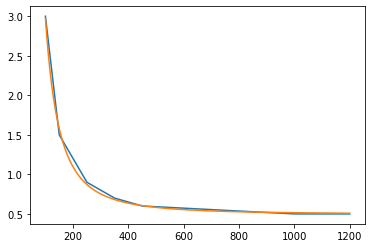

In [194]:
plt.plot(x, y)
plt.plot(x_sim, func(x_sim, *popt))

In [197]:
func(800, *popt)

0.5271850884259257

## Hardcoding function for beads amount calculations

Parameters for DNA size vs. amount of magnetic beads are figured by a manufacturer, and rendered to be always constant. Therefore, I am simply hardcoding them

In [82]:
def calcBeadsVol(sample_vol, DNA_size_cutoff):
    multiplier = 4.99325349e-01 - 9.91043764e+00 / DNA_size_cutoff + 2.57585836e+04 / DNA_size_cutoff ** 2
    return sample_vol * multiplier

In [83]:
calcBeadsVol(50, 100)

148.80396663000002

# Removing upper cutoff DNA

In [121]:
# Estimating volume that needs to be added to the tubes
vol_to_add = [calcBeadsVol(x[0].getVolume(), x[1]) for x in zip(sample_list, upper_cutoff_list)]
vol_to_add

[25.758674747999997,
 29.126940406000003,
 21.50944475608163,
 17.032099118061222,
 12.879337373999999]

In [85]:
# I can use p200 pipette for this
p200 = tools.pipettor.getTool(robot=ar, tool_name='p200_tool')

In [86]:
xt, yt, zt = calibration.calibrateTool(p200, stp)

In [143]:
def fillSamplesOneByOneFromOneTube(tool, tip_rack, source, samples_list, vol_list, z=400, blow_extra=False):
    for sample, vol in zip(samples_list, vol_list):
        xn, yn = tip_rack.getNextConsumable()
        tool.pickUpTip(tip_rack, xn, yn, raise_z=z)
        tool.moveLiquid(source, sample, vol, blow_extra=blow_extra)
        tool.pipetteUpAndDown(sample, uptake_volume=vol*0.7, repeats=3, uptake_delay=0.5)
        dropTipToWaste(tool=tool, x_slot=5, y_slot=3, z=z)

In [88]:
# Filling tubes one by one; because I will need to touch liquid, 
# as I am pipetting very low volume
beads_vol_list = []
for sample, cutoff in zip(sample_list, upper_cutoff_list):
    sample_vol = sample.getVolume()
    beads_vol = calcBeadsVol(sample_vol, cutoff)
    beads_vol_list.append(beads_vol)

In [122]:
beads_vol_list

[25.758674747999997,
 58.253880812000006,
 75.2830566462857,
 112.41185417920407,
 97.88296404239999]

In [90]:
timestamp = time.time()

In [91]:
fillSamplesOneByOneFromOneTube(tool=p200, tip_rack=p200_tip_rack, 
                               source=magbeads, samples_list=sample_list, 
                               vol_list=beads_vol_list, blow_extra=True, z=400)

In [93]:
p200.returnTool()

In [94]:
waitFromTimeStamp(timestamp, 5 * 60)

In [104]:
# This is for updating sample volume without actually filling the sample
# temp
for sample, vol_to_add in zip(sample_list, ):
    
    print (sample.getVolume())

50
50
40
25
25


## Moving tubes to magnetic rack

In [95]:
gr = tools.mobile_gripper.getTool(robot=ar)

In [96]:
calibration.calibrateToolCustomPoints(tool=gr, stationary_probe=stp)

(94.94999999999999, 67.1, 514.9)

In [99]:
ar.move(z=400)

In [123]:
timestamp = time.time()
for sample in sample_list:
    col_number = sample.sample_data['x_well']
    sample = gr.moveSample(sample, magep1, col_number, 1)

In [124]:
gr.operateGripper(0)

In [125]:
gr.returnTool()

In [126]:
waitFromTimeStamp(timestamp, 2 * 60)

## Moving liquid with desired DNA to the new set of tubes

In [127]:
# We are using p200 again, as we are dealing with less than 200 uL at any sample
p200 = tools.pipettor.getTool(robot=ar, tool_name='p200_tool')

In [128]:
xt, yt, zt = calibration.calibrateTool(p200, stp)

In [129]:
for init_sample, dest_sample in zip(sample_list, upper_cut_samples):
    xn, yn = p200_tip_rack.getNextConsumable()
    p200.pickUpTip(p200_tip_rack, xn, yn, raise_z=400)
    p200.uptakeAll(init_sample)
    p200.dispenseLiquid(dest_sample, 200, blow_extra=True)
    dropTipToWaste(tool=p200, x_slot=5, y_slot=3, z=300)

In [130]:
p200.returnTool()

## Dropping empty tubes to the trash

In [131]:
gr = tools.mobile_gripper.getTool(robot=ar)

In [132]:
calibration.calibrateToolCustomPoints(tool=gr, stationary_probe=stp)

(94.9, 67.2, 514.9)

In [135]:
gr.gripper_has_something = False

In [136]:
for sample in sample_list:
    gr.grabSample(sample)
    gr.robot.move(z=300)
    x, y = param.calcSquareSlotCenterFromVertices(5, 3)
    gr.robot.move(x=x, y=y)
    gr.operateGripper(140)
    gr.gripper_has_something = False
    gr.operateGripper(0)

In [137]:
gr.returnTool()

# Removing lower cutoff DNA

In [138]:
# Calculating volume that needs to be added
# upper_cutoff * star_vol - lower_cutoff * start_vol
for vol, up_cutoff, low_cutoff in zip(vol_list, upper_cutoff_list, lower_cutoff_list):
    upper_cutoff_vol = calcBeadsVol(vol, up_cutoff)
    lower_cutoff_vol = calcBeadsVol(vol, low_cutoff)
    print (lower_cutoff_vol - upper_cutoff_vol)

17.832372054000004
119.67702622400002
97.53372854791839
22.419943444716555
14.464106395999998


## Adding more magnetic beads

In [139]:
p200 = tools.pipettor.getTool(robot=ar, tool_name='p200_tool')

In [140]:
xt, yt, zt = calibration.calibrateTool(p200, stp)

In [141]:
beads_vol_list = []
for sample, vol, up_cutoff, lower_cutoff in zip(upper_cut_samples, vol_list, upper_cutoff_list, lower_cutoff_list):
    upcutoff_beads_vol = calcBeadsVol(vol, up_cutoff)
    lowcutoff_beads_vol = calcBeadsVol(vol, lower_cutoff)
    beads_vol = lowcutoff_beads_vol - upcutoff_beads_vol
    beads_vol_list.append(beads_vol)

In [142]:
beads_vol_list

[17.832372054000004,
 119.67702622400002,
 97.53372854791839,
 22.419943444716555,
 14.464106395999998]

In [144]:
timestamp = time.time()

In [146]:
dropTipToWaste(tool=p200, x_slot=5, y_slot=3, z=400)

In [147]:
fillSamplesOneByOneFromOneTube(tool=p200, tip_rack=p200_tip_rack, 
                               source=magbeads, samples_list=upper_cut_samples, 
                               vol_list=beads_vol_list, z=400)

In [148]:
p200.returnTool()

In [149]:
waitFromTimeStamp(timestamp, 5 * 60)

## Moving samples to magnetic rack

In [150]:
gr = tools.mobile_gripper.getTool(robot=ar)

In [151]:
calibration.calibrateToolCustomPoints(tool=gr, stationary_probe=stp)

(95.4, 67.0, 515.05)

In [152]:
ar.move(z=400)

In [153]:
timestamp = time.time()
for sample in upper_cut_samples:
    col_number = sample.sample_data['x_well']
    sample = gr.moveSample(sample, magep1, col_number, 1)

In [154]:
gr.operateGripper(0)

In [155]:
gr.returnTool()

In [156]:
waitFromTimeStamp(timestamp, 2 * 60)

## Removing empty liquid from the tubes

In [159]:
ar.home()

In [157]:
# Total volume still should be less than 200 uL in each tube; however,
# I am doing it with 1000 uL pipette, because ethanol wash will require that one
p1000 = tools.pipettor.getTool(robot=ar, tool_name='p1000_tool')

In [160]:
xt, yt, zt = calibration.calibrateTool(p1000, stp)

In [161]:
for sample in upper_cut_samples:
    xn, yn = p1000_tip_rack.getNextConsumable()
    p1000.pickUpTip(p1000_tip_rack, xn, yn, raise_z=400)
    p1000.uptakeAll(sample)
    p1000.dispenseLiquid(waste, 1000, blow_extra=True)
    dropTipToWaste(tool=p1000, x_slot=5, y_slot=3, z=300)

## Performing 1st ethanol wash

In [162]:
# Putting ethanol to the samples
xn, yn = p1000_tip_rack.getNextConsumable()
p1000.pickUpTip(p1000_tip_rack, xn, yn, raise_z=400)
ethanol_vol_list = [200 for x in sample_list]
timestamp = time.time()
p1000.distributeLiquid(ethanol, upper_cut_samples, ethanol_vol_list, raise_z=300)
dropTipToWaste(tool=p1000, x_slot=5, y_slot=3, z=300)

In [ ]:
waitFromTimeStamp(timestamp, 30)

In [164]:
dropTipToWaste(tool=p1000, x_slot=5, y_slot=3, z=300)

In [165]:
# Removing ethanol from the tubes
for sample in upper_cut_samples:
    xn, yn = p1000_tip_rack.getNextConsumable()
    p1000.pickUpTip(p1000_tip_rack, xn, yn, raise_z=400)
    p1000.uptakeAll(sample, volume=400, immerse_levels_list=[20, 0], uptake_delay=0.5)
    p1000.dispenseLiquid(waste, 1000, blow_extra=True)
    dropTipToWaste(tool=p1000, x_slot=5, y_slot=3, z=300)

## Performing second ethanol wash

In [166]:
# Putting ethanol to the samples
xn, yn = p1000_tip_rack.getNextConsumable()
p1000.pickUpTip(p1000_tip_rack, xn, yn, raise_z=400)
ethanol_vol_list = [200 for x in sample_list]
timestamp = time.time()
p1000.distributeLiquid(ethanol, upper_cut_samples, ethanol_vol_list, raise_z=300)
dropTipToWaste(tool=p1000, x_slot=5, y_slot=3, z=300)

In [ ]:
waitFromTimeStamp(timestamp, 30)

In [168]:
# Removing ethanol from the tubes
for sample in upper_cut_samples:
    xn, yn = p1000_tip_rack.getNextConsumable()
    p1000.pickUpTip(p1000_tip_rack, xn, yn, raise_z=400)
    p1000.uptakeAll(sample, volume=400, immerse_levels_list=[20, 0], uptake_delay=0.5)
    p1000.dispenseLiquid(waste, 1000, blow_extra=True)
    dropTipToWaste(tool=p1000, x_slot=5, y_slot=3, z=300)

In [169]:
p1000.returnTool()

In [170]:
# Uptaking the remaining ethanol from the tubes
p20 = tools.pipettor.getTool(robot=ar, tool_name='p20_tool')

In [171]:
xt, yt, zt = calibration.calibrateTool(p20, stp)

In [172]:
for sample in upper_cut_samples:
    xn, yn = p20_tip_rack.getNextConsumable()
    p20.pickUpTip(p20_tip_rack, xn, yn, raise_z=300)
    p20.uptakeAll(sample, volume=10, immerse_levels_list=[20, 0], uptake_delay=0.5)
    p20.dispenseLiquid(waste, 20, blow_extra=True)
    dropTipToWaste(tool=p20, x_slot=5, y_slot=3, z=300)

In [ ]:
timestamp = time.time()

In [173]:
p20.returnTool()

## Moving tubes back to normal rack

In [174]:
gr = tools.mobile_gripper.getTool(robot=ar)

In [175]:
calibration.calibrateToolCustomPoints(tool=gr, stationary_probe=stp)

(94.75, 66.9, 515.05)

In [176]:
ar.move(z=400)

In [177]:
timestamp = time.time()
for sample in upper_cut_samples:
    col_number = sample.sample_data['x_well']
    sample = gr.moveSample(sample, ep1, col_number, 3)

In [178]:
gr.operateGripper(0)

In [179]:
gr.returnTool()

# Eluting DNA from beads

In [180]:
# Here I must release liquid directly onto the beads pellet
# I make a new function to do that

In [182]:
def dispenceLiquidWithXYShift(tool, sample, volume, dx=0, dy=0,
                              release_delay=0, immerse_volume=None, plunger_retract=True, blow_extra=True):
    """
    Allows to dispence liquid to a sample while specifying shift from the center
    """
    # Getting to the center of the sample
    tool.getToSample(sample=sample)
    # Shifting relative to the center
    tool.robot.moveAxisDelta(axis='x', value=dx)
    tool.robot.moveAxisDelta(axis='y', value=dy)
    # Finding sample's maximum volume
    max_vol = sample.getMaxVolume()
    # Lowering tip into the tube
    # But first checking if the depth to immerse is specified
    # TODO: add also heigth to immerse, and % of tube height
    if immerse_volume is None:
        immerse_vol_fraction = max_vol * 0.1
        # Currently tip will be immersed to 10% of the volume
        # TODO: make it so user can specify percent themselves.
        immerse_volume = max_vol - immerse_vol_fraction
    # Actually lowering tip
    z_immerse = sample.sampleVolToZ(volume=immerse_volume, tool=tool)
    tool.robot.move(z=z_immerse)
    # Actually dispensing the liquid
    tool.movePlungerToVol(volume)
    # Updating volume amount in the tube
    old_sample_vol = sample.getVolume()
    new_sample_vol = old_sample_vol + volume
    sample.setVolume(new_sample_vol)
    # Not lifting the tip, in case you need to touch the wall or liquid,
    # or pipette up and down.
    # If requested, returning plunger back to 0.
    # Some cases may require not retracting plunger, such as serial_device
    # filling of many tubes with one liquid
    if blow_extra:
        tool.movePlunger(-40)
    if plunger_retract:
        # Now lifting the tip, if plunger retraction was chosen
        z_retract = sample.sampleVolToZ(volume=max_vol + max_vol * 0.2, tool=tool)
        tool.robot.move(z=z_retract)
        tool.movePlungerToVol(0)

In [183]:
p20 = tools.pipettor.getTool(robot=ar, tool_name='p20_tool')

In [184]:
xt, yt, zt = calibration.calibrateTool(p20, stp)

In [185]:
ar.move(z=400)

In [ ]:
waitFromTimeStamp(timestamp, 5 * 60)

In [186]:
elution_vol_list = [20 for x in sample_list]

In [187]:
timestamp = time.time()
for sample, vol in zip(upper_cut_samples, elution_vol_list):
    xn, yn = p20_tip_rack.getNextConsumable()
    p20.pickUpTip(p20_tip_rack, xn, yn, raise_z=400)
    p20.uptakeLiquid(water, vol)
    dispenceLiquidWithXYShift(p20, sample, vol, dy=-5, immerse_volume=1000)
    # Repeatedly washing the bead pellet from the wall
    # Repeat as needed
    p20.uptakeLiquid(sample, 15, uptake_delay=1)
    dispenceLiquidWithXYShift(p20, sample, 15, dy=-5, immerse_volume=1000)
    p20.uptakeLiquid(sample, 15, uptake_delay=1)
    dispenceLiquidWithXYShift(p20, sample, 15, dy=-5, immerse_volume=1000)
    p20.uptakeLiquid(sample, 15, uptake_delay=1)
    dispenceLiquidWithXYShift(p20, sample, 15, dy=-5, immerse_volume=1000)
    
    dropTipToWaste(tool=p20, x_slot=5, y_slot=3, z=300)

KeyboardInterrupt: 

In [188]:
p20.home()

In [189]:
p20.returnTool()

## Moving tubes back to magnetic rack

In [ ]:
gr = tools.mobile_gripper.getTool(robot=ar)

In [ ]:
calibration.calibrateToolCustomPoints(tool=gr, stationary_probe=stp)

In [ ]:
ar.move(z=400)

In [ ]:
waitFromTimeStamp(timestamp, 5 * 60)

In [ ]:
timestamp = time.time()
for sample in sample_list:
    col_number = sample.sample_data['x_well']
    sample = gr.moveSample(sample, ep1, col_number, 3)

In [ ]:
gr.returnTool()

## Transferring liquid with eluted DNA to empty tubes

In [ ]:
p20 = tools.pipettor.getTool(robot=ar, tool_name='p20_tool')

In [ ]:
xt, yt, zt = calibration.calibrateTool(p20, stp)

In [ ]:
ar.move(z=300)

In [ ]:
waitFromTimeStamp(timestamp, 2 * 60)

for eluted_sample, result_sample in zip(upper_cut_samples, result_samples):
    xn, yn = p20_tip_rack.getNextConsumable()
    p20.pickUpTip(p20_tip_rack, xn, yn, raise_z=300)
    p20.uptakeAll(eluted_sample)
    p20.dispenseLiquid(result_sample, 20, blow_extra=True)
    # Repeating so we do not miss anything
    p20.uptakeAll(eluted_sample)
    p20.dispenseLiquid(result_sample, 20, blow_extra=True)
    
    dropTipToWaste(tool=p20, x_slot=5, y_slot=3, z=300)

In [190]:
ar.home()